## Loading Libraries

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, countDistinct, count, regexp_replace, mean, when, ceil,log, exp, year,lit,round
from pyspark.sql.functions import sum as psum
from operator import or_  
from functools import reduce  
from scipy.stats import ttest_ind

In [3]:
spark = SparkSession.builder \
    .appName("avm2") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.instances", "4") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

# Set log level to ERROR to reduce verbosity
spark.sparkContext.setLogLevel("ERROR")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/06 12:42:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/06 12:42:38 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Merging Primary Data with Prediction Data for Web App

This part involves combining the gradient boosting model's prediction data with the essential attributes from the primary dataset that will be shown in our web application.

In [7]:
schema = StructType([
    StructField("address_hash", StringType(), nullable=True),
    StructField("lmk_key", StringType(), nullable=True),
    StructField("building_reference_number", StringType(), nullable=True),
    StructField("current_energy_rating", StringType(), nullable=True),
    StructField("potential_energy_rating", StringType(), nullable=True),
    StructField("current_energy_efficiency", FloatType(), nullable=True),
    StructField("potential_energy_efficiency", FloatType(), nullable=True),
    StructField("property_type", StringType(), nullable=True),
    StructField("build_form", StringType(), nullable=True),
    StructField("inspection_date", TimestampType(), nullable=True),#date
    StructField("local_authority", StringType(), nullable=True),
    StructField("constituency", StringType(), nullable=True),
    StructField("county", StringType(), nullable=True),
    StructField("lodgement_date", TimestampType(), nullable=True),#date
    StructField("transaction_type", StringType(), nullable=True),
    StructField("environment_impact_current", FloatType(), nullable=True),
    StructField("environment_impact_potential", FloatType(), nullable=True),
    StructField("energy_consumption_current", FloatType(), nullable=True),
    StructField("energy_consumption_potential", FloatType(), nullable=True),
    StructField("co2_emissions_current", FloatType(), nullable=True),
    StructField("co2_emiss_curr_per_floor_area", FloatType(), nullable=True),
    StructField("co2_emissions_potential", FloatType(), nullable=True),
    StructField("lighting_cost_current", FloatType(), nullable=True),
    StructField("lighting_cost_potential", FloatType(), nullable=True),
    StructField("heating_cost_current", FloatType(), nullable=True),
    StructField("heating_cost_potential", FloatType(), nullable=True),
    StructField("hot_water_cost_current", FloatType(), nullable=True),
    StructField("hot_water_cost_potential", FloatType(), nullable=True),
    StructField("total_floor_area", FloatType(), nullable=True),
    StructField("energy_tariff", StringType(), nullable=True),
    StructField("mains_gas_flag", StringType(), nullable=True),
    StructField("floor_level", StringType(), nullable=True),
    StructField("flat_top_storey", StringType(), nullable=True),
    StructField("flat_storey_count", FloatType(), nullable=True),
    StructField("main_heating_controls", StringType(), nullable=True),
    StructField("multi_glaze_proportion", FloatType(), nullable=True),
    StructField("glazed_type", StringType(), nullable=True),
    StructField("glazed_area", StringType(), nullable=True),
    StructField("extension_count", FloatType(), nullable=True),
    StructField("number_habitable_rooms", FloatType(), nullable=True),
    StructField("number_heated_rooms", FloatType(), nullable=True),
    StructField("low_energy_lighting", FloatType(), nullable=True),
    StructField("number_open_fireplaces", FloatType(), nullable=True),
    StructField("hotwater_description", StringType(), nullable=True),
    StructField("hot_water_energy_eff", StringType(), nullable=True),
    StructField("hot_water_env_eff", StringType(), nullable=True),
    StructField("floor_description", StringType(), nullable=True),
    StructField("floor_energy_eff", StringType(), nullable=True),
    StructField("floor_env_eff", StringType(), nullable=True),
    StructField("windows_description", StringType(), nullable=True),
    StructField("windows_energy_eff", StringType(), nullable=True),
    StructField("windows_env_eff", StringType(), nullable=True),
    StructField("walls_description", StringType(), nullable=True),
    StructField("walls_energy_eff", StringType(), nullable=True),
    StructField("walls_env_eff", StringType(), nullable=True),
    StructField("secondheat_description", StringType(), nullable=True),
    StructField("sheating_energy_eff", StringType(), nullable=True),
    StructField("sheating_env_eff", StringType(), nullable=True),
    StructField("roof_description", StringType(), nullable=True),
    StructField("roof_energy_eff", StringType(), nullable=True),
    StructField("roof_env_eff", StringType(), nullable=True),
    StructField("mainheat_description", StringType(), nullable=True),
    StructField("mainheat_energy_eff", StringType(), nullable=True),
    StructField("mainheat_env_eff", StringType(), nullable=True),
    StructField("mainheatcont_description", StringType(), nullable=True),
    StructField("mainheatc_energy_eff", StringType(), nullable=True),
    StructField("mainheatc_env_eff", StringType(), nullable=True),
    StructField("lighting_description", StringType(), nullable=True),
    StructField("lighting_energy_eff", StringType(), nullable=True),
    StructField("lighting_env_eff", StringType(), nullable=True),
    StructField("main_fuel", StringType(), nullable=True),
    StructField("wind_turbine_count", FloatType(), nullable=True),
    StructField("heat_loss_corridor", StringType(), nullable=True),
    StructField("unheated_corridor_length", FloatType(), nullable=True),
    StructField("floor_height", FloatType(), nullable=True),
    StructField("photo_supply", FloatType(), nullable=True),
    StructField("solar_water_heating_flag", StringType(), nullable=True),
    StructField("mechanical_ventilation", StringType(), nullable=True),
    StructField("epc_address", StringType(), nullable=True),
    StructField("local_authority_label", StringType(), nullable=True),
    StructField("constituency_label", StringType(), nullable=True),
    StructField("construction_age_band", StringType(), nullable=True),
    StructField("lodgement_datetime", TimestampType(), nullable=True),#date
    StructField("tenure", StringType(), nullable=True),
    StructField("fixed_lighting_outlets_count", FloatType(), nullable=True),
    StructField("low_energy_fixed_light_count", FloatType(), nullable=True),
    StructField("improvement_id", StringType(), nullable=True),
    StructField("improvement_item_id", StringType(), nullable=True),
    StructField("improvement_id_text", StringType(), nullable=True),
    StructField("min_indicative_cost", StringType(), nullable=True),
    StructField("max_indicative_cost", StringType(), nullable=True),
    StructField("typical_yearly_savings", StringType(), nullable=True),
    StructField("rating_after_improvement", StringType(), nullable=True),
    StructField("sap_after_improvement", StringType(), nullable=True),
    StructField("env_after_improvement", StringType(), nullable=True),
    StructField("envsap_after_improvement", StringType(), nullable=True),
    StructField("address_hash_1", StringType(), nullable=True),
    StructField("min_cost", FloatType(), nullable=True),
    StructField("mid_cost", FloatType(), nullable=True),
    StructField("max_cost", FloatType(), nullable=True),
    StructField("min_cost_incl_service_maintenance", FloatType(), nullable=True),
    StructField("mid_cost_incl_service_maintenance", FloatType(), nullable=True),
    StructField("max_cost_incl_service_maintenance", FloatType(), nullable=True),
    StructField("total_ltv_inflated", FloatType(), nullable=True),
    StructField("total_affordability", FloatType(), nullable=True),
    StructField("total_seg", FloatType(), nullable=True),
    StructField("green_val", FloatType(), nullable=True),
    StructField("net_present_value", FloatType(), nullable=True),
    StructField("postcode", StringType(), nullable=True),
    StructField("uprn", StringType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("lon", FloatType(), nullable=True),
    StructField("lad22nm", StringType(), nullable=True),
    StructField("lad22cd", StringType(), nullable=True),
    StructField("lsoa11cd", StringType(), nullable=True),
    StructField("uid", StringType(), nullable=True),
    StructField("price", IntegerType(), nullable=True),
    StructField("date_of_transfer", TimestampType(), nullable=True),
    StructField("price_paid_property_type", StringType(), nullable=True),
    StructField("old_new", BooleanType(), nullable=True),
    StructField("address_hash_2", StringType(), nullable=True),
    StructField("propertyIsBungalow", BooleanType(), nullable=True),
    StructField("propertyIsFlat", BooleanType(), nullable=True),
    StructField("propertyIsHouse", BooleanType(), nullable=True),
    StructField("propertyIsMaisonette", BooleanType(), nullable=True),
    StructField("propertyIsParkHome", BooleanType(), nullable=True),
    StructField("propertyIsDetached", BooleanType(), nullable=True),
    StructField("propertyIsEnclosedTerrace", BooleanType(), nullable=True),
    StructField("propertyIsEnclosedMidTerrace", BooleanType(), nullable=True),
    StructField("propertyIsEndTerrace", BooleanType(), nullable=True),
    StructField("propertyIsMidTerrace", BooleanType(), nullable=True),
    StructField("propertyIsSemiDetached", BooleanType(), nullable=True),
    StructField("propertyInEngland", BooleanType(), nullable=True),
    StructField("propertyInScotland", BooleanType(), nullable=True),
    StructField("propertyInWales", BooleanType(), nullable=True),
    StructField("propertyHasFlatRoof", IntegerType(), nullable=True),
    StructField("propertyHasPitchedRoof", IntegerType(), nullable=True),
    StructField("propertyIsNewBuildFlat", IntegerType(), nullable=True),
    StructField("propertyHasRoofInsulation", IntegerType(), nullable=True),
    StructField("propertyTotalFloorArea", IntegerType(), nullable=True),
    StructField("propertyBelowEPCE", BooleanType(), nullable=True),
    StructField("propertyAboveCommercialPremises", BooleanType(), nullable=True),
    StructField("propertyAboveFoodOutlets", BooleanType(), nullable=True),
    StructField("propertyIsCloseToCommercialOutlets", BooleanType(), nullable=True),
    StructField("propertyIsDualUse", BooleanType(), nullable=True),
    StructField("propertyIsHolidayHome", BooleanType(), nullable=True),
    StructField("propertyIsGradeIListed", BooleanType(), nullable=True),
    StructField("propertyIsGradeIIListed", BooleanType(), nullable=True),
    StructField("propertyIsGradeIIStarListed", BooleanType(), nullable=True),
    StructField("gradeListing", StringType(), nullable=True),
    StructField("conservationArea", BooleanType(), nullable=True),
    StructField("address_hash_3", StringType(), nullable=True),
    StructField("amenities_pub_bar_restaurant", IntegerType(), nullable=True),
    StructField("area_neighbours", FloatType(), nullable=True),
    StructField("education_facilities_higher", IntegerType(), nullable=True),
    StructField("education_facilities_pre_school", IntegerType(), nullable=True),
    StructField("education_facilities_school", IntegerType(), nullable=True),
    StructField("leisure_facilities_exercise", IntegerType(), nullable=True),
    StructField("leisure_facilities_parks", IntegerType(), nullable=True),
    StructField("public_transport_bus_tram", IntegerType(), nullable=True),
    StructField("public_transport_train_underground", IntegerType(), nullable=True),
    StructField("retail_services_banking", IntegerType(), nullable=True),
    StructField("retail_services_newsagent", IntegerType(), nullable=True),
    StructField("retail_services_post_office", IntegerType(), nullable=True),
    StructField("support_services_healthcare", IntegerType(), nullable=True),
    StructField("liabilities_flood_risk_category", FloatType(), nullable=True),
    StructField("liabilities_radon", FloatType(), nullable=True),
    StructField("liabilities_industrial_areas", IntegerType(), nullable=True),
    StructField("noise_roads", IntegerType(), nullable=True),
    StructField("liabilities_collapsibledeposits", FloatType(), nullable=True),
    StructField("liabilities_compressibleground", FloatType(), nullable=True),
    StructField("liabilities_landslides", FloatType(), nullable=True),
    StructField("liabilities_runningsand", FloatType(), nullable=True),
    StructField("liabilities_shrinkswell", FloatType(), nullable=True),
    StructField("liabilities_solublerocks", FloatType(), nullable=True),
    StructField("buildinguse", StringType(), nullable=True),
    StructField("connectivity", StringType(), nullable=True),
    StructField("constructionmaterial", StringType(), nullable=True),
    StructField("buildingage_year", FloatType(), nullable=True),
    StructField("lsoa11cd_1", StringType(), nullable=True),
    StructField("lsoa11nm", StringType(), nullable=True),
    StructField("lsoa11nmw", StringType(), nullable=True),
    StructField("st_areasha", FloatType(), nullable=True),
    StructField("st_lengths", FloatType(), nullable=True),
    StructField("imd_rank", IntegerType(), nullable=True),
    StructField("imd_decile", IntegerType(), nullable=True),
    StructField("lsoa01nm", StringType(), nullable=True),
    StructField("ladcd", StringType(), nullable=True),
    StructField("ladnm", StringType(), nullable=True),
    StructField("imdscore", FloatType(), nullable=True),
    StructField("imdrank0", IntegerType(), nullable=True),
    StructField("imddec0", IntegerType(), nullable=True),
    StructField("incscore", FloatType(), nullable=True),
    StructField("incrank", IntegerType(), nullable=True),
    StructField("incdec", IntegerType(), nullable=True),
    StructField("empscore", FloatType(), nullable=True),
    StructField("emprank", IntegerType(), nullable=True),
    StructField("empdec", IntegerType(), nullable=True),
    StructField("eduscore", FloatType(), nullable=True),
    StructField("edurank", IntegerType(), nullable=True),
    StructField("edudec", IntegerType(), nullable=True),
    StructField("hddscore", FloatType(), nullable=True),
    StructField("hddrank", IntegerType(), nullable=True),
    StructField("hdddec", IntegerType(), nullable=True),
    StructField("criscore", FloatType(), nullable=True),
    StructField("crirank", IntegerType(), nullable=True),
    StructField("cridec", IntegerType(), nullable=True),
    StructField("bhsscore", FloatType(), nullable=True),
    StructField("bhsrank", IntegerType(), nullable=True),
    StructField("bhsdec", IntegerType(), nullable=True),
    StructField("envscore", FloatType(), nullable=True),
    StructField("envrank", IntegerType(), nullable=True),
    StructField("envdec", IntegerType(), nullable=True),
    StructField("idcscore", FloatType(), nullable=True),
    StructField("idcrank", IntegerType(), nullable=True),
    StructField("idcdec", IntegerType(), nullable=True),
    StructField("idoscore", FloatType(), nullable=True),
    StructField("idorank", IntegerType(), nullable=True),
    StructField("idodec", IntegerType(), nullable=True),
    StructField("cypscore", FloatType(), nullable=True),
    StructField("cyprank", IntegerType(), nullable=True),
    StructField("cypdec", IntegerType(), nullable=True),
    StructField("asscore", FloatType(), nullable=True),
    StructField("asrank", IntegerType(), nullable=True),
    StructField("asdec", IntegerType(), nullable=True),
    StructField("gbscore", FloatType(), nullable=True),
    StructField("gbrank", IntegerType(), nullable=True),
    StructField("gbdec", IntegerType(), nullable=True),
    StructField("wbscore", FloatType(), nullable=True),
    StructField("wbrank", IntegerType(), nullable=True),
    StructField("wbdec", IntegerType(), nullable=True),
    StructField("indscore", FloatType(), nullable=True),
    StructField("indrank", IntegerType(), nullable=True),
    StructField("inddec", IntegerType(), nullable=True),
    StructField("outscore", FloatType(), nullable=True),
    StructField("outrank", IntegerType(), nullable=True),
    StructField("outdec", IntegerType(), nullable=True),
    StructField("totpop", IntegerType(), nullable=True),
    StructField("depchi", IntegerType(), nullable=True),
    StructField("pop16_59", IntegerType(), nullable=True),
    StructField("pop60", IntegerType(), nullable=True),
    StructField("workpop", FloatType(), nullable=True)]

)

In [8]:
#primary data
start_time =time.time()
df= spark.read.csv("/Users/riyamac/Desktop/data/data_students_combined_primary_data_dedup_full.csv",header=False,schema=schema,inferSchema=False,quote='"', escape='"')
end_time = time.time()
execution_time = end_time - start_time
num_rows = df.count()
num_columns = len(df.columns)

print("shape:{} rows and columns:{}".format(num_rows,num_columns))
print("execution time:", execution_time,"seconds")

shape:8854277 rows and columns:242
execution time: 1.2318029403686523 seconds


In [21]:
#prediction data
pred_df = pd.read_csv("join.csv")

In [10]:
#merging both the datasets with required features
dld = df.select('postcode', 'epc_address', 'price', 
        'number_habitable_rooms', 'total_floor_area', 
        'current_energy_rating', 'tenure', 'lat', 'lon', 'property_type','build_form','date_of_transfer','uprn').toPandas()

pred_df['uprn'] = pred_df['uprn'].astype(str)
dld['uprn'] = dld['uprn'].astype(str)

df_final = pd.merge(dld, pred_df[['uprn', 'prediction','is_solar_panel']], on='uprn', how='inner')

print(df_final.head())

  postcode                                        epc_address    price  \
0  CV312EQ     74B, BRUNSWICK STREET, LEAMINGTON SPA, CV312EQ    43500   
1  BN148DF           10, WESTBOURNE AVENUE, WORTHING, BN148DF   378000   
2   IG96BZ             6, PENTLOW WAY, BUCKHURST HILL, IG96BZ   395000   
3  DY121ES                    78, QUEENSWAY, BEWDLEY, DY121ES   147000   
4  SG127SJ  NOBLAND GREEN FARM, NOBLAND GREEN, UNCLASSFIED...  1211000   

   number_habitable_rooms  total_floor_area current_energy_rating  \
0                     4.0              91.0                     E   
1                     5.0             124.0                     E   
2                     4.0              91.0                     D   
3                     4.0              71.0                     D   
4                     5.0             139.0                     E   

             tenure        lat       lon property_type     build_form  \
0    Owner-occupied  52.278088 -1.529530    Maisonette       Detach

In [11]:
#final dataset to be included in the web app
df_final.to_csv('final.csv', index = False) 

In [4]:
# Read the CSV file
dfc = pd.read_csv("final.csv")

# Save the dataframe as a Feather file
dfc.to_feather("finaldata.feather")

## Retrofit Improvement effect
In this section, we are discovering What is the additional value of retrofit improvement work? For example, how would installing solar panels raise the value of a property? Apply t-tests to several houses with similar specifications.

In [3]:
#loading the final data
df = pd.read_csv("final.csv") 

In [22]:
# Filter the dataset to create groups of similar properties
filtered_df = df[(df['number_habitable_rooms'] == 5) & 
                 (df['total_floor_area'].between(100, 150)) &
                 (df['property_type'].isin(['House'])) &
                 (df['build_form'].isin(['Semi-Detached']))]

df['is_solar_panel_binary'] = df['is_solar_panel'].apply(lambda x: 1 if x.lower() == 'yes' else 0)

# Separate the prediction values based on the binary solar panel column
solar_panel_predictions = filtered_df[filtered_df['is_solar_panel_binary'] == 1]['prediction']
no_solar_panel_predictions = filtered_df[filtered_df['is_solar_panel_binary'] == 0]['prediction']

t_stat, p_value = ttest_ind(solar_panel_predictions, no_solar_panel_predictions, equal_var=False)
print(f"T-test result: t-statistic = {t_stat}, p-value = {p_value}")


T-test result: t-statistic = 18.65581582727951, p-value = 3.522501959012891e-75


In [27]:
# Filter the dataset to create groups of similar properties
filtered_df = df[(df['number_habitable_rooms'] == 4) & 
                 (df['total_floor_area'].between(50, 100)) &
                 (df['property_type'].isin(['House'])) &
                 (df['build_form'].isin(['Detached']))]

df['is_solar_panel_binary'] = df['is_solar_panel'].apply(lambda x: 1 if x.lower() == 'yes' else 0)

# Separate the prediction values based on the binary solar panel column
solar_panel_predictions = filtered_df[filtered_df['is_solar_panel_binary'] == 1]['prediction']
no_solar_panel_predictions = filtered_df[filtered_df['is_solar_panel_binary'] == 0]['prediction']

t_stat, p_value = ttest_ind(solar_panel_predictions, no_solar_panel_predictions, equal_var=False)
print(f"T-test result: t-statistic = {t_stat}, p-value = {p_value}")


T-test result: t-statistic = 4.050043937669804, p-value = 5.271176012421496e-05


In [31]:
# Filter the dataset to create groups of similar properties
filtered_df = df[(df['number_habitable_rooms'] == 5) & 
                 (df['total_floor_area'].between(100, 150)) &
                 (df['property_type'].isin(['Bungalow'])) &
                 (df['build_form'].isin(['Detached']))]

df['is_solar_panel_binary'] = df['is_solar_panel'].apply(lambda x: 1 if x.lower() == 'yes' else 0)

# Separate the prediction values based on the binary solar panel column
solar_panel_predictions = filtered_df[filtered_df['is_solar_panel_binary'] == 1]['prediction']
no_solar_panel_predictions = filtered_df[filtered_df['is_solar_panel_binary'] == 0]['prediction']

t_stat, p_value = ttest_ind(solar_panel_predictions, no_solar_panel_predictions, equal_var=False)
print(f"T-test result: t-statistic = {t_stat}, p-value = {p_value}")


T-test result: t-statistic = 10.882731157072568, p-value = 3.3471675765096565e-27


In [38]:
# Filter the dataset to create groups of similar properties
filtered_df = df[(df['number_habitable_rooms'] == 4) & 
                 (df['total_floor_area'].between(100, 150)) &
                 (df['property_type'].isin(['Bungalow'])) &
                 (df['build_form'].isin(['Semi-Detached']))]

df['is_solar_panel_binary'] = df['is_solar_panel'].apply(lambda x: 1 if x.lower() == 'yes' else 0)

# Separate the prediction values based on the binary solar panel column
solar_panel_predictions = filtered_df[filtered_df['is_solar_panel_binary'] == 1]['prediction']
no_solar_panel_predictions = filtered_df[filtered_df['is_solar_panel_binary'] == 0]['prediction']

t_stat, p_value = ttest_ind(solar_panel_predictions, no_solar_panel_predictions, equal_var=False)
print(f"T-test result: t-statistic = {t_stat}, p-value = {p_value}")


T-test result: t-statistic = 4.291031406012726, p-value = 2.5904159270025897e-05


## Benchmarking

This section compares our AVM, utilising a variety of techniques, to commercial AVMs such as RightMove and Zoopla.

In [39]:
#loading the dataset with 100 diverse property values from each model
df = pd.read_csv('bm.csv')

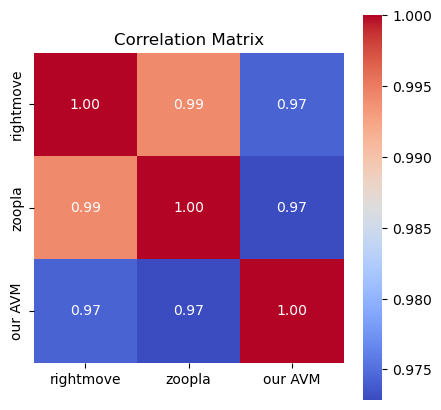

In [40]:
#correlation analysis
correlations = df.corr(method='pearson')


plt.figure(figsize=(5, 5))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Matrix")
plt.show()


In [42]:
#MAE 

df['mae_rightmove'] = abs(df['our AVM'] - df['rightmove'])
df['mae_zoopla'] = abs(df['our AVM'] - df['zoopla'])

mae_rightmove = df['mae_rightmove'].mean()
mae_zoopla = df['mae_zoopla'].mean()

print(f'MAE between Our AVM and Rightmove: {mae_rightmove}')
print(f'MAE between Our AVM and Zoopla: {mae_zoopla}')


MAE between Our AVM and Rightmove: 84601.66
MAE between Our AVM and Zoopla: 89778.72


In [43]:
#Scaled MAE
# Function to perform min-max scaling
def min_max_scale(values):
    return (values - np.min(values)) / (np.max(values) - np.min(values))

# Scale the actual and predicted values for Rightmove and Zoopla
scaled_myavm = min_max_scale(df['our AVM'])
scaled_rightmove = min_max_scale(df['rightmove'])
scaled_zoopla = min_max_scale(df['zoopla'])

# Function to calculate MAE
def calculate_mae(actual, predicted):
    return np.mean(np.abs(actual - predicted))

# Calculate scaled MAE
mae_scaled_rightmove = calculate_mae(scaled_myavm, scaled_rightmove)
mae_scaled_zoopla = calculate_mae(scaled_myavm, scaled_zoopla)

print(f"Scaled MAE between our AVM and Rightmove: {mae_scaled_rightmove}")
print(f"Scaled MAE between our AVM and Zoopla: {mae_scaled_zoopla}")

Scaled MAE between our AVM and Rightmove: 0.01807258918779451
Scaled MAE between our AVM and Zoopla: 0.01694539021163385


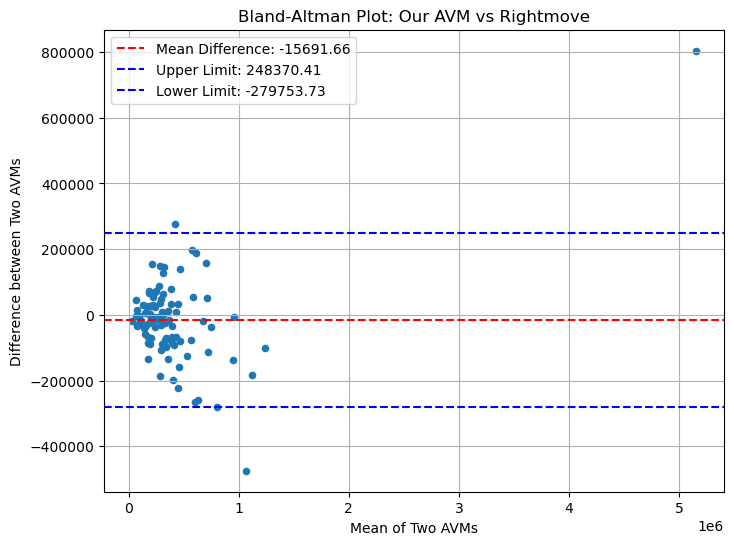

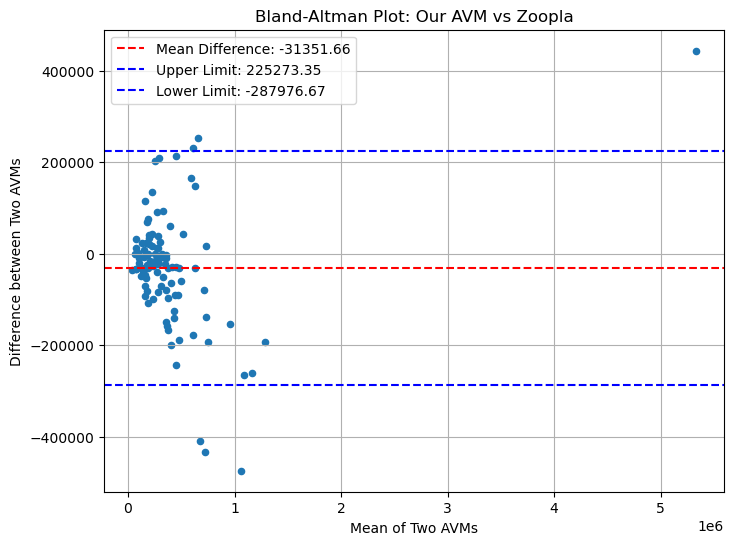

In [44]:
# Function to create Bland-Altman plot
def bland_altman_plot(data1, data2, title='Bland-Altman Plot'):
    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2  # Difference between data1 and data2
    md = np.mean(diff)    # Mean of the difference
    sd = np.std(diff, axis=0)  # Standard deviation of the difference

    plt.figure(figsize=(8, 6))
    plt.scatter(mean, diff, s=20)
    plt.axhline(md, color='red', linestyle='--', label=f'Mean Difference: {md:.2f}')
    plt.axhline(md + 1.96*sd, color='blue', linestyle='--', label=f'Upper Limit: {md + 1.96*sd:.2f}')
    plt.axhline(md - 1.96*sd, color='blue', linestyle='--', label=f'Lower Limit: {md - 1.96*sd:.2f}')
    plt.title(title)
    plt.xlabel('Mean of Two AVMs')
    plt.ylabel('Difference between Two AVMs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create Bland-Altman plot for OurAVM vs Rightmove
bland_altman_plot(df['our AVM'], df['rightmove'], title='Bland-Altman Plot: Our AVM vs Rightmove')

# Create Bland-Altman plot for OurAVM vs Zoopla
bland_altman_plot(df['our AVM'], df['zoopla'], title='Bland-Altman Plot: Our AVM vs Zoopla')


In [45]:
#MPE

df['mpe_rightmove'] = (df['our AVM'] - df['rightmove']) / df['rightmove'] * 100
df['mpe_zoopla'] = (df['our AVM'] - df['zoopla']) / df['zoopla'] * 100

mpe_rightmove = df['mpe_rightmove'].mean()
mpe_zoopla = df['mpe_zoopla'].mean()

print(f'MPE between Our AVM and Rightmove: {mpe_rightmove}%')
print(f'MPE between Our AVM and Zoopla: {mpe_zoopla}%')


MPE between Our AVM and Rightmove: -1.179051250605708%
MPE between Our AVM and Zoopla: -2.4535066699516204%


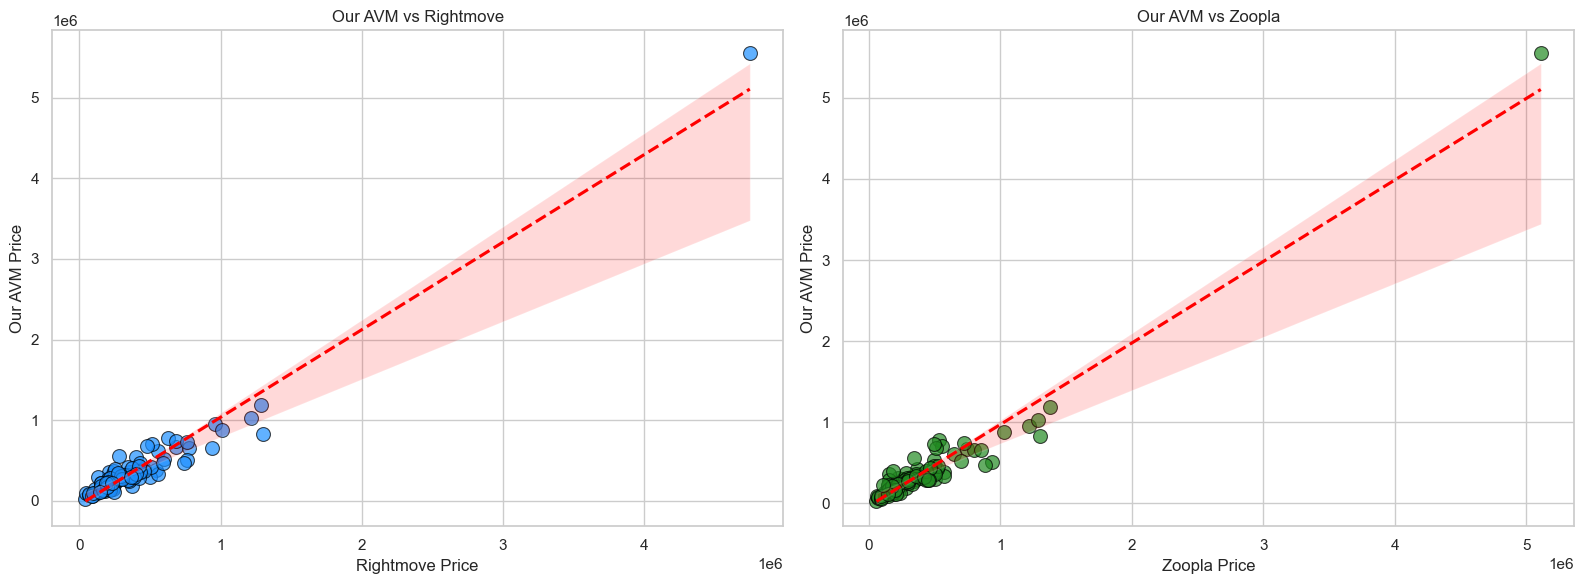

In [46]:
#Scatterplot

# Set a theme for the plots
sns.set_theme(style="whitegrid")

# Create a 1x2 figure layout
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot for OurAVM vs Rightmove
sns.scatterplot(ax=axes[0], x='rightmove', y='our AVM', data=df, color="dodgerblue", s=100, edgecolor="black", alpha=0.7)
sns.regplot(ax=axes[0], x='rightmove', y='our AVM', data=df, scatter=False, color="red", line_kws={"linestyle":"--"})
axes[0].set_title('Our AVM vs Rightmove')
axes[0].set_xlabel('Rightmove Price', fontsize=12)
axes[0].set_ylabel('Our AVM Price', fontsize=12)
axes[0].grid(True)

# Scatter plot for OurAVM vs Zoopla
sns.scatterplot(ax=axes[1], x='zoopla', y='our AVM', data=df, color="forestgreen", s=100, edgecolor="black", alpha=0.7)
sns.regplot(ax=axes[1], x='zoopla', y='our AVM', data=df, scatter=False, color="red", line_kws={"linestyle":"--"})
axes[1].set_title('Our AVM vs Zoopla')
axes[1].set_xlabel('Zoopla Price', fontsize=12)
axes[1].set_ylabel('Our AVM Price', fontsize=12)
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


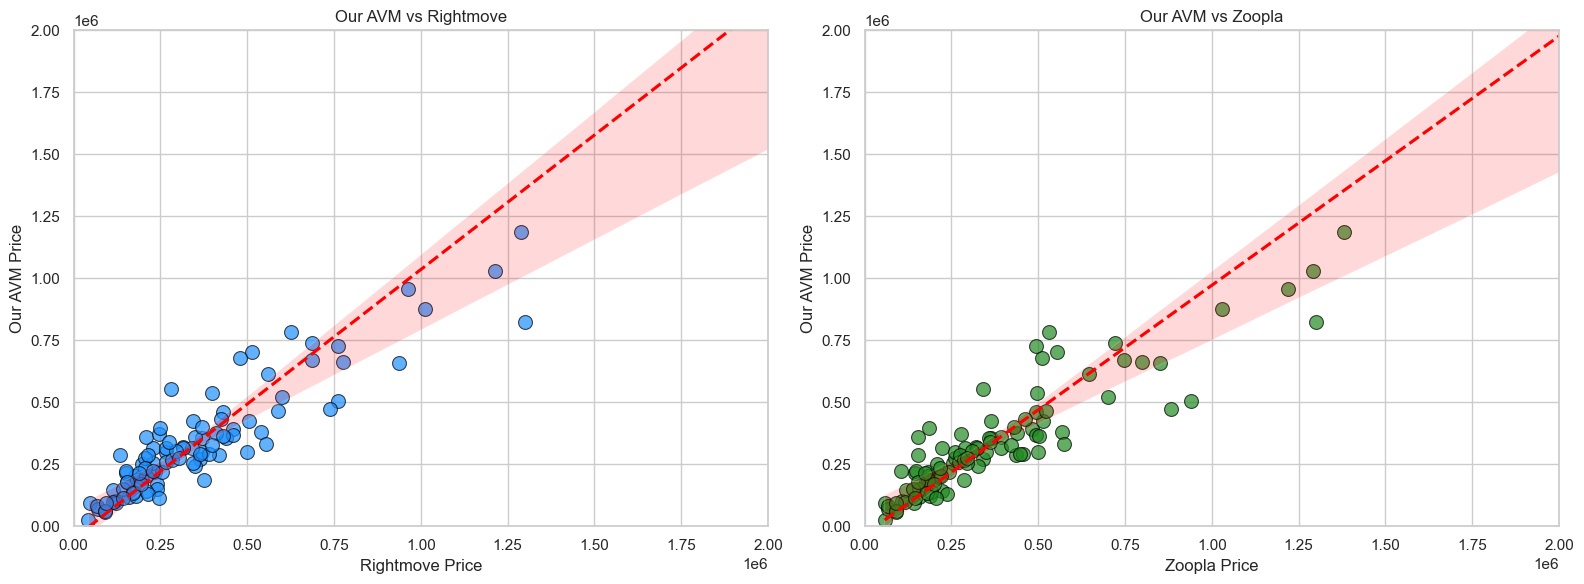

In [47]:
#zoomed in Scatter plot

# Set a theme for the plots
sns.set_theme(style="whitegrid")

# Create a 1x2 figure layout
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot for OurAVM vs Rightmove
sns.scatterplot(ax=axes[0], x='rightmove', y='our AVM', data=df, color="dodgerblue", s=100, edgecolor="black", alpha=0.7)
sns.regplot(ax=axes[0], x='rightmove', y='our AVM', data=df, scatter=False, color="red", line_kws={"linestyle":"--"})
axes[0].set_title('Our AVM vs Rightmove')
axes[0].set_xlabel('Rightmove Price', fontsize=12)
axes[0].set_ylabel('Our AVM Price', fontsize=12)
axes[0].set_xlim(0, 2e6)  # Set x-axis limits between 0 and 2 million
axes[0].set_ylim(0, 2e6)  # Set y-axis limits between 0 and 2 million
axes[0].grid(True)

# Scatter plot for OurAVM vs Zoopla
sns.scatterplot(ax=axes[1], x='zoopla', y='our AVM', data=df, color="forestgreen", s=100, edgecolor="black", alpha=0.7)
sns.regplot(ax=axes[1], x='zoopla', y='our AVM', data=df, scatter=False, color="red", line_kws={"linestyle":"--"})
axes[1].set_title('Our AVM vs Zoopla')
axes[1].set_xlabel('Zoopla Price', fontsize=12)
axes[1].set_ylabel('Our AVM Price', fontsize=12)
axes[1].set_xlim(0, 2e6)  # Set x-axis limits between 0 and 2 million
axes[1].set_ylim(0, 2e6)  # Set y-axis limits between 0 and 2 million
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
